In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid

from livelossplot import PlotLosses

# If on drive retrieve the images
try:
    from google.colab import drive
    drive.mount('/content/drive')
    data_path = '/content/drive/My Drive/Fiber/images.zip'
    local_path = '/content/'
    !cp -r "$data_path" "$local_path"
    !unzip "/content/images.zip" -d "/content" > /dev/null 2>&1
    !rmdir -rf __MACOSX
    print('Data recieved and unzipped!')

except Exception as e:
    print('No Drive or Error:', e)

data_path = './images'

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

No Drive or Error: No module named 'google.colab'
No GPU available!


In [2]:
class HandDataset(Dataset):
    """Creates a dataset from an image file."""
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.files = os.listdir(image_dir)
        self.image_paths = []

        self.labels = {}
        self.false = []
        
        self._parse_files()

    def _parse_files(self):
        for file_name in self.files:
            file_name = os.path.join(self.image_dir, file_name)
            if file_name.endswith(".png"):
                self.image_paths.append(file_name)
            elif file_name.endswith(".csv"):
                labels = pd.read_csv(file_name, header=None)[0]
                labels.index += 1
                labels = dict(labels)
                self.labels = labels
            else:
                self.false.append(file_name)
        pass

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        file_name = self.image_paths[idx]
        image_no = int(file_name.split("/")[-1].replace(".png", ""))
        image = Image.open(file_name).convert('L')

        label = self.labels[image_no]

        if self.transform:
            image = self.transform(image)

        return image, label


transform = transforms.Compose([transforms.ToTensor()])

data_path_bio = data_path + "/bio/"
dataset = HandDataset(data_path_bio, transform=transform)
exp_loader = DataLoader(dataset, batch_size=1, shuffle=False)


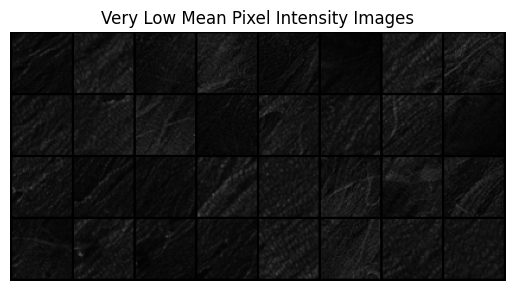

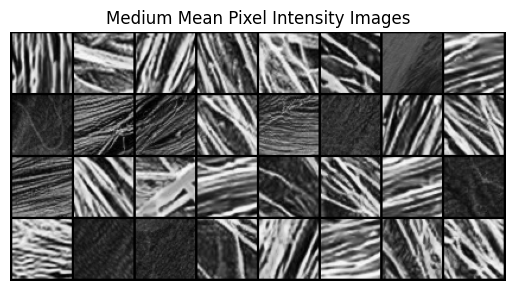

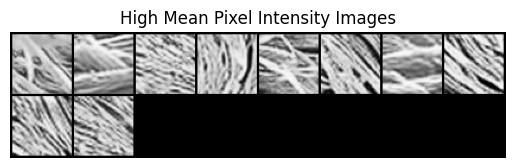

In [3]:
def show_images_grid(images, title=None, nrow=8):
    """Plots the images in a grid"""
    img_grid = make_grid(images, nrow=nrow).numpy()
    plt.imshow(np.transpose(img_grid, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

# DataLoader for the dataset
exp_loader = DataLoader(dataset, shuffle=True)

# Thresholds
low_threshold = 0.1
high_threshold = 0.65

# Lists to store samples
very_low_mean_samples = []
medium_mean_samples = []
high_mean_samples = []

for images, labels in exp_loader:
    for img in images:
        mean_intensity = img.mean()
        if mean_intensity <= low_threshold and len(very_low_mean_samples) < 32:
            very_low_mean_samples.append(img)
        elif low_threshold < mean_intensity <= high_threshold and len(medium_mean_samples) < 32:
            medium_mean_samples.append(img)
        elif mean_intensity > high_threshold and len(high_mean_samples) < 32:
            high_mean_samples.append(img)

    if len(very_low_mean_samples) >= 32 and len(medium_mean_samples) >= 32 and len(high_mean_samples) >= 32:
        break

show_images_grid(very_low_mean_samples, "Very Low Mean Pixel Intensity Images")
show_images_grid(medium_mean_samples, "Medium Mean Pixel Intensity Images")
show_images_grid(high_mean_samples, "High Mean Pixel Intensity Images")

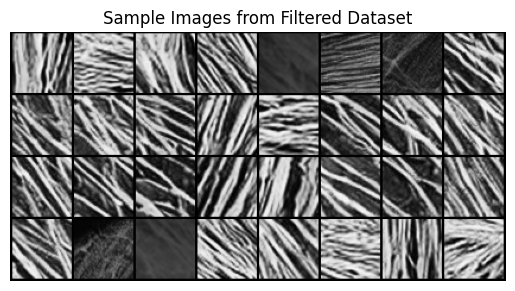

In [4]:
class FilteredDataset(Dataset):
    """Creates a filtered set from the standard dataset using tresholds."""
    def __init__(self, original_dataset, low_threshold=0., high_threshold=1, transform=None):
        self.transform = transform
        self.data = [(img, label) for img, label in original_dataset if low_threshold < img.mean() <= high_threshold]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx][0]
        label = self.data[idx][1]

        if self.transform:
            image = self.transform(image)

        return image, label


transform = transforms.Compose([transforms.ToTensor()])

dataset = HandDataset(data_path_bio, transform=transform)
filtered_dataset = FilteredDataset(dataset, low_threshold=.1, high_threshold=.65)
filtered_loader = DataLoader(filtered_dataset, batch_size=1, shuffle=False)
filtered_samples = []

for i, data in enumerate(filtered_dataset):
    image = data[0]
    filtered_samples.append(image)
    if i >= 31:
        break

show_images_grid(filtered_samples, "Sample Images from Filtered Dataset")


In [5]:
transform = transforms.Compose([transforms.ToTensor()])

dataset = HandDataset(data_path_bio, transform=transform)
filtered_dataset = FilteredDataset(dataset, low_threshold=.1, high_threshold=.65)
loader = DataLoader(filtered_dataset, batch_size=12, shuffle=False)

In [6]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.activation = nn.Tanh() # *finetuned
        self.dropout = nn.Dropout(0.5) # *finetuned
        self.fc = nn.Sequential(
            nn.Linear(50*50, 1024),
            self.activation,
            self.dropout,

            nn.Linear(1024, 512),
            self.activation,
            self.dropout,

            nn.Linear(512, 256),
            self.activation,
        )

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        return self.fc(x)

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.activation = nn.Tanh() # *finetuned
        self.dropout = nn.Dropout(0.3) # *finetuned
        self.fc = nn.Sequential(
            nn.Linear(256, 512),
            self.activation,
            self.dropout,

            nn.Linear(512, 1024),
            self.activation,
            self.dropout,

            nn.Linear(1024, 50*50),
            nn.Sigmoid()
        )

    def forward(self, z):
        z = self.fc(z)
        return z.reshape((-1, 1, 50, 50))
    
class VariationalAutoencoder(nn.Module):
  def __init__(self, dims_latent):
    super(VariationalAutoencoder, self).__init__()
    self.dims_latent = dims_latent
    self.encoder = Encoder()
    self.decoder = Decoder()

    self.layerMu = nn.Linear(Encoder().fc[6].out_features, dims_latent)
    self.layerSig = nn.Linear(Encoder().fc[6].out_features, dims_latent)
    self.distribution = torch.distributions.Normal(0, 1)

    self.latentOut = nn.Linear(dims_latent, Decoder().fc[0].in_features)
    self.activationOut = nn.Sigmoid()

  def vae_latent_space(self, x):
    mu =  self.layerMu(x)
    sigma = torch.exp(self.layerSig(x))
    z = mu + sigma * self.distribution.sample(mu.shape).to(device)
    kl_div = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
    return z, kl_div

  def forward(self, x):
    x = self.encoder(x)
    z, kl_div = self.vae_latent_space(x)
    z = self.activationOut(self.latentOut(z))
    return self.decoder(z), kl_div

In [7]:
def train(model, optimizer, data, epochs, plot_interval=10):
    liveloss = PlotLosses(groups={'S': ['Rec_Loss', 'KL_Loss'], 'T': ['loss']})
    beta = 8e-1  # Scale for KL loss - finetuned
    saved_images = []

    for epoch in range(epochs):
        logs = {}
        train_loss, train_rl_div, train_kl_div = 0.0, 0.0, 0.0

        for batch, _ in data:
            batch = batch.to(device)
            optimizer.zero_grad()
            x_hat, KL = model(batch)
            reconstruction_loss = ((batch - x_hat)**2).sum()
            loss = reconstruction_loss + beta * KL
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_rl_div += reconstruction_loss.item()
            train_kl_div += KL.item()

        logs['Rec_Loss'] = train_rl_div / len(data.dataset)
        logs['KL_Loss'] = train_kl_div / len(data.dataset)
        logs['loss'] = train_loss / len(data.dataset)

        liveloss.update(logs)
        liveloss.send()

        # Save images every `plot_interval` epochs
        if (epoch + 1) % plot_interval == 0:
            saved_images.append((epoch + 1, generate_images(model)))

    return model, saved_images

def generate_images(model, num_samples=8):
    z = torch.randn(num_samples, model.dims_latent).to(device)
    model.eval()
    with torch.no_grad():
        imgs = model.decoder(model.activationOut(model.latentOut(z))).to('cpu')
    return imgs

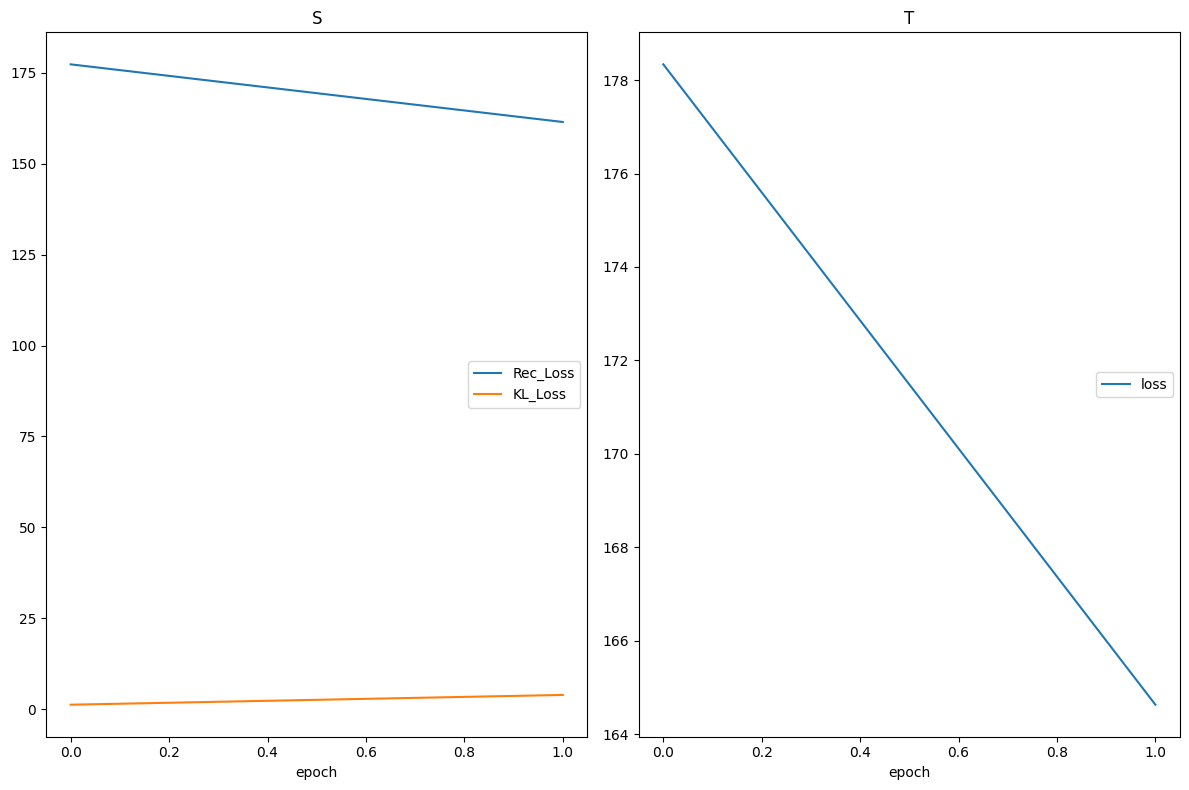

S
	Rec_Loss         	 (min:  161.504, max:  177.359, cur:  161.504)
	KL_Loss          	 (min:    1.222, max:    3.907, cur:    3.907)
T
	loss             	 (min:  164.630, max:  178.336, cur:  164.630)


In [8]:
def plot_saved_images(saved_images):
    for epoch, imgs in saved_images:
        img_grid = make_grid(imgs).numpy()
        plt.figure(figsize=(6, 3))
        plt.imshow(np.transpose(img_grid, (1, 2, 0)), cmap='gray')
        plt.axis('off')
        plt.title(f'Samples at Epoch {epoch}')
        plt.show()

epochs= 50
lr = 1e-4 # *finetuned
dims_latent = 2 # *finetuned
weight_decay = 1e-1 # *finetuned
VAE = VariationalAutoencoder(dims_latent).to(device)
optimizer = torch.optim.Adam(VAE.parameters(), lr=lr, weight_decay=weight_decay)

VAE, saved_images = train(VAE, optimizer, filtered_loader, epochs)

# Plot all saved images vs epoch
plot_saved_images(saved_images)

In [ ]:
def plot_samples(model, num_samples=32, nrow=8, save=False, model_type='VAE'):
    save_dir=f'./{model_type}_hands'
    # Generate random latent vectors
    z = torch.randn(num_samples, model.dims_latent).to(device)
    
    # Decode the latent vectors
    model.eval()
    with torch.no_grad():
        imgs = model.decoder(model.activationOut(model.latentOut(z))).to('cpu')

    # Create a grid of images and display
    img_grid = make_grid(imgs, nrow=nrow)
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(img_grid.numpy(), (1, 2, 0)), cmap='gray')
    plt.axis('off')
    plt.show()

    # Save the images if requested
    if save:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        for i, img in enumerate(imgs):
            fname = f'{str(i+1).zfill(3)}.jpeg'
            img_np = img.squeeze().numpy()
            if img_np.max() <= 1:
                img_np = (img_np * 255).astype(np.uint8)
            img_pil = Image.fromarray(img_np)
            img_pil.save(os.path.join(save_dir, fname))

# plot_samples(VAE, num_samples=300, nrow= 20, save=False)
plot_samples(VAE, num_samples=300, nrow= 20, save=False, model_type='VAE')